In [3]:
# Install necessary packages
%pip install tensorflow numpy tqdm pandas scikit-learn matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 847.3 kB/s eta 0:00:00 0:00:01
  Using cached scikit_learn-1.5.1-cp312-cp312-macosx_10_9_x86_64.whl.metadata (12 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
Using cached scikit_learn-1.5.1-cp312-cp312-macosx_10_9_x86_64.whl (12.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
import gzip
import os
from tqdm import tqdm
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Function to load MNIST images from .gz file
def load_mnist_images(file_path):
    with gzip.open(file_path, 'r') as f:
        f.read(16)  # Skip metadata
        buffer = f.read()
        images = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        images = images / 255.0  # Normalize to [0, 1]
        images = images.reshape(-1, 28 * 28)
    return images

# Function to load MNIST labels from .gz file
def load_mnist_labels(file_path):
    with gzip.open(file_path, 'r') as f:
        f.read(8)  # Skip metadata
        buffer = f.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)
    return labels

# Load the MNIST dataset from the directory
mnist_dir = '../MNIST'
train_images = load_mnist_images(os.path.join(mnist_dir, 'train-images-idx3-ubyte.gz'))
test_images = load_mnist_images(os.path.join(mnist_dir, 't10k-images-idx3-ubyte.gz'))
train_labels = load_mnist_labels(os.path.join(mnist_dir, 'train-labels-idx1-ubyte.gz'))
test_labels = load_mnist_labels(os.path.join(mnist_dir, 't10k-labels-idx1-ubyte.gz'))

print(f"Training images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 784)
Test images shape: (10000, 784)
Training labels shape: (60000,)
Test labels shape: (10000,)


In [ ]:
class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, momentum=0.9, batch_size=64, epochs=10, dropout_rate=0.2):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout_rate = dropout_rate

        # Xavier Initialization for weights
        initializer = tf.initializers.GlorotNormal()
        self.W = tf.Variable(initializer([self.visible_units, self.hidden_units]))

        self.h_bias = tf.Variable(tf.zeros([self.hidden_units]))  # Hidden layer bias
        self.v_bias = tf.Variable(tf.zeros([self.visible_units]))  # Visible layer bias

        # Initialize momentum terms
        self.dW_momentum = tf.zeros_like(self.W)
        self.dh_bias_momentum = tf.zeros_like(self.h_bias)
        self.dv_bias_momentum = tf.zeros_like(self.v_bias)

    def sample_prob(self, probs):
        """Sample binary values based on probabilities."""
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def forward(self, X):
        """Propagate input data to hidden layer."""
        h_prob = tf.nn.sigmoid(tf.matmul(X, self.W) + self.h_bias)  # P(h|v)
        h_prob = tf.nn.dropout(h_prob, rate=self.dropout_rate)
        return h_prob

    def backward(self, h):
        """Propagate from hidden layer to visible layer."""
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)  # P(v|h)
        return v_prob

    def train(self, data, rbm_layer):
        """Train the RBM for unsupervised pretraining with real-time reconstruction error tracking."""
        print(f"\nTraining RBM {rbm_layer}: {self.visible_units} visible units -> {self.hidden_units} hidden units\n")

        for epoch in range(self.epochs):
            total_reconstruction_error = 0  # Track total reconstruction error for this epoch
            pbar = tqdm(total=len(data) // self.batch_size, desc=f'Epoch {epoch + 1}/{self.epochs}', unit='batch')

            for batch in range(0, data.shape[0], self.batch_size):
                X_batch = data[batch:batch+self.batch_size]
                h_prob = self.forward(X_batch)
                h_sample = self.sample_prob(h_prob)
                v_prob_reconstructed = self.backward(h_sample)
                h_prob_reconstructed = self.forward(v_prob_reconstructed)

                # Calculate reconstruction error (MSE between original and reconstructed input)
                reconstruction_error = tf.reduce_mean(tf.square(X_batch - v_prob_reconstructed))
                total_reconstruction_error += reconstruction_error

                # Contrastive Divergence
                positive_grad = tf.matmul(tf.transpose(X_batch), h_prob)
                negative_grad = tf.matmul(tf.transpose(v_prob_reconstructed), h_prob_reconstructed)

                # Update weights and biases with momentum
                dW = (positive_grad - negative_grad) / self.batch_size
                dv_bias = tf.reduce_mean(X_batch - v_prob_reconstructed, axis=0)
                dh_bias = tf.reduce_mean(h_prob - h_prob_reconstructed, axis=0)

                # Apply momentum to updates
                self.dW_momentum = self.momentum * self.dW_momentum + self.learning_rate * dW
                self.dv_bias_momentum = self.momentum * self.dv_bias_momentum + self.learning_rate * dv_bias
                self.dh_bias_momentum = self.momentum * self.dh_bias_momentum + self.learning_rate * dh_bias

                # Update parameters
                self.W.assign_add(self.dW_momentum)
                self.v_bias.assign_add(self.dv_bias_momentum)
                self.h_bias.assign_add(self.dh_bias_momentum)

                # Update progress bar with real-time reconstruction error
                pbar.set_postfix({'Reconstruction Error': reconstruction_error.numpy()})
                pbar.update(1)

            pbar.close()

            avg_reconstruction_error = total_reconstruction_error / (len(data) // self.batch_size)
            print(f'[Avg Reconstruction Error: {avg_reconstruction_error.numpy():.6f}]\n')

        # Return the learned hidden features for the next layer
        return self.forward(data)


In [ ]:
# Train RBM 1
rbm_1 = RBM(visible_units=784, hidden_units=512, learning_rate=0.01, momentum=0.9, batch_size=256, epochs=15)
h1 = rbm_1.train(train_images, rbm_layer=1)

# Train RBM 2
rbm_2 = RBM(visible_units=512, hidden_units=256, learning_rate=0.001, momentum=0.9, batch_size=256, epochs=10)
h2 = rbm_2.train(h1, rbm_layer=2)

# Train RBM 3
rbm_3 = RBM(visible_units=256, hidden_units=128, learning_rate=0.001, momentum=0.9, batch_size=256, epochs=10)
h3 = rbm_3.train(h2, rbm_layer=3)

# Train RBM 4
rbm_4 = RBM(visible_units=128, hidden_units=64, learning_rate=0.001, momentum=0.9, batch_size=256, epochs=10)
h4 = rbm_4.train(h3, rbm_layer=4)

# Collect all RBM layers into a list
rbm_layers = [rbm_1, rbm_2, rbm_3, rbm_4]


Training RBM 1: 784 visible units -> 512 hidden units



Epoch 1/15: 235batch [00:02, 90.96batch/s, Reconstruction Error=0.0255]                      


[Avg Reconstruction Error: 0.037164]



Epoch 2/15: 235batch [00:02, 84.39batch/s, Reconstruction Error=0.0203]                      


[Avg Reconstruction Error: 0.021345]



Epoch 3/15: 235batch [00:02, 90.56batch/s, Reconstruction Error=0.0184]                      


[Avg Reconstruction Error: 0.018204]



Epoch 4/15: 235batch [00:02, 92.69batch/s, Reconstruction Error=0.017]                      


[Avg Reconstruction Error: 0.016651]



Epoch 5/15: 235batch [00:02, 91.87batch/s, Reconstruction Error=0.0159]                      


[Avg Reconstruction Error: 0.015632]



Epoch 6/15: 235batch [00:02, 90.05batch/s, Reconstruction Error=0.0157]                      


[Avg Reconstruction Error: 0.014994]



Epoch 7/15: 235batch [00:02, 88.10batch/s, Reconstruction Error=0.015]                      


[Avg Reconstruction Error: 0.014477]



Epoch 8/15: 235batch [00:02, 91.30batch/s, Reconstruction Error=0.0148]


[Avg Reconstruction Error: 0.014119]



Epoch 9/15: 235batch [00:02, 91.08batch/s, Reconstruction Error=0.0143]                      


[Avg Reconstruction Error: 0.013841]



Epoch 10/15: 235batch [00:02, 89.19batch/s, Reconstruction Error=0.0138]                      


[Avg Reconstruction Error: 0.013597]



Epoch 11/15: 235batch [00:02, 88.86batch/s, Reconstruction Error=0.0137]                      


[Avg Reconstruction Error: 0.013401]



Epoch 12/15: 235batch [00:02, 86.67batch/s, Reconstruction Error=0.0137]                      


[Avg Reconstruction Error: 0.013250]



Epoch 13/15: 235batch [00:02, 89.83batch/s, Reconstruction Error=0.0136]                      


[Avg Reconstruction Error: 0.013126]



Epoch 14/15: 235batch [00:02, 88.68batch/s, Reconstruction Error=0.0134]                      


[Avg Reconstruction Error: 0.013002]



Epoch 15/15: 235batch [00:02, 89.93batch/s, Reconstruction Error=0.0133]


[Avg Reconstruction Error: 0.012905]


Training RBM 2: 512 visible units -> 256 hidden units



Epoch 1/10: 235batch [00:02, 111.57batch/s, Reconstruction Error=0.165]                      


[Avg Reconstruction Error: 0.171853]



Epoch 2/10: 235batch [00:02, 113.27batch/s, Reconstruction Error=0.145]                      


[Avg Reconstruction Error: 0.141608]



Epoch 3/10: 235batch [00:02, 113.15batch/s, Reconstruction Error=0.137]                      


[Avg Reconstruction Error: 0.130107]



Epoch 4/10: 235batch [00:01, 118.37batch/s, Reconstruction Error=0.131]                      


[Avg Reconstruction Error: 0.123644]



Epoch 5/10: 235batch [00:01, 117.57batch/s, Reconstruction Error=0.126]


[Avg Reconstruction Error: 0.119060]



Epoch 6/10: 235batch [00:01, 119.45batch/s, Reconstruction Error=0.123]                      


[Avg Reconstruction Error: 0.115689]



Epoch 7/10: 235batch [00:02, 114.45batch/s, Reconstruction Error=0.12]                      


[Avg Reconstruction Error: 0.113110]



Epoch 8/10: 235batch [00:02, 112.81batch/s, Reconstruction Error=0.118]                      


[Avg Reconstruction Error: 0.111074]



Epoch 9/10: 235batch [00:01, 124.85batch/s, Reconstruction Error=0.117]                      


[Avg Reconstruction Error: 0.109417]



Epoch 10/10: 235batch [00:01, 119.98batch/s, Reconstruction Error=0.114]                      


[Avg Reconstruction Error: 0.108010]


Training RBM 3: 256 visible units -> 128 hidden units



Epoch 1/10: 235batch [00:01, 125.97batch/s, Reconstruction Error=0.18]                      


[Avg Reconstruction Error: 0.206578]



Epoch 2/10: 235batch [00:02, 117.24batch/s, Reconstruction Error=0.152]                      


[Avg Reconstruction Error: 0.166110]



Epoch 3/10: 235batch [00:01, 121.39batch/s, Reconstruction Error=0.14]                      


[Avg Reconstruction Error: 0.149319]



Epoch 4/10: 235batch [00:02, 111.04batch/s, Reconstruction Error=0.134]                      


[Avg Reconstruction Error: 0.140945]



Epoch 5/10: 235batch [00:01, 121.56batch/s, Reconstruction Error=0.13]                      


[Avg Reconstruction Error: 0.135298]



Epoch 6/10: 235batch [00:02, 117.47batch/s, Reconstruction Error=0.126]                      


[Avg Reconstruction Error: 0.131130]



Epoch 7/10: 235batch [00:01, 119.35batch/s, Reconstruction Error=0.123]                      


[Avg Reconstruction Error: 0.127930]



Epoch 8/10: 235batch [00:01, 125.23batch/s, Reconstruction Error=0.121]                      


[Avg Reconstruction Error: 0.125485]



Epoch 9/10: 235batch [00:01, 118.19batch/s, Reconstruction Error=0.118]                      


[Avg Reconstruction Error: 0.123555]



Epoch 10/10: 235batch [00:01, 118.43batch/s, Reconstruction Error=0.118]                      


[Avg Reconstruction Error: 0.122052]


Training RBM 4: 128 visible units -> 64 hidden units



Epoch 1/10: 235batch [00:02, 112.63batch/s, Reconstruction Error=0.22]                      


[Avg Reconstruction Error: 0.240761]



Epoch 2/10: 235batch [00:01, 121.22batch/s, Reconstruction Error=0.186]                      


[Avg Reconstruction Error: 0.197517]



Epoch 3/10: 235batch [00:02, 115.49batch/s, Reconstruction Error=0.169]                      


[Avg Reconstruction Error: 0.174802]



Epoch 4/10: 235batch [00:01, 121.52batch/s, Reconstruction Error=0.162]                      


[Avg Reconstruction Error: 0.163534]



Epoch 5/10: 235batch [00:01, 120.03batch/s, Reconstruction Error=0.154]                      


[Avg Reconstruction Error: 0.156407]



Epoch 6/10: 235batch [00:02, 113.76batch/s, Reconstruction Error=0.152]                      


[Avg Reconstruction Error: 0.151971]



Epoch 7/10: 235batch [00:02, 113.52batch/s, Reconstruction Error=0.147]                      


[Avg Reconstruction Error: 0.148696]



Epoch 8/10: 235batch [00:02, 116.68batch/s, Reconstruction Error=0.146]                      


[Avg Reconstruction Error: 0.146082]



Epoch 9/10: 235batch [00:02, 116.53batch/s, Reconstruction Error=0.144]                      


[Avg Reconstruction Error: 0.144075]



Epoch 10/10: 235batch [00:01, 120.96batch/s, Reconstruction Error=0.14]                      

[Avg Reconstruction Error: 0.142524]



In [ ]:
# Now you can integrate these pre-trained RBM layers into a Deep Belief Network (DBN)
def create_dbn_model(rbm_layers):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28 * 28,)),
        tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.constant_initializer(rbm_layers[0].W.numpy()), bias_initializer=tf.constant_initializer(rbm_layers[0].h_bias.numpy())),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.constant_initializer(rbm_layers[1].W.numpy()), bias_initializer=tf.constant_initializer(rbm_layers[1].h_bias.numpy())),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.constant_initializer(rbm_layers[2].W.numpy()), bias_initializer=tf.constant_initializer(rbm_layers[2].h_bias.numpy())),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.constant_initializer(rbm_layers[3].W.numpy()), bias_initializer=tf.constant_initializer(rbm_layers[3].h_bias.numpy())),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# One-Hot Encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
labels_onehot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# One-Hot Encode the test labels
test_labels_onehot = one_hot_encoder.transform(test_labels.reshape(-1, 1))

# Convert data to NumPy arrays for indexing
train_images_array = np.array(train_images)
labels_onehot_array = np.array(labels_onehot)

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

val_accuracies = []
fold = 1

for train_index, val_index in kf.split(train_images_array):
    print(f"Fold {fold}/{k}")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = train_images_array[train_index], train_images_array[val_index]
    y_train_fold, y_val_fold = labels_onehot_array[train_index], labels_onehot_array[val_index]

    # Create a new instance of the model for each fold
    dbn_model = create_dbn_model(rbm_layers)

    # Define callbacks (optional: you can save models per fold)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-5)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'final_dbn_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True)

    # Fine-tune the DBN
    dbn_model.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=2
    )

    # Evaluate on the validation fold
    val_loss, val_accuracy = dbn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold}: {val_accuracy:.4f}")
    val_accuracies.append(val_accuracy)

    fold += 1

Fold 1/5
Epoch 1/100
1500/1500 - 9s - 6ms/step - accuracy: 0.9011 - loss: 0.3317 - val_accuracy: 0.9691 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 2/100
1500/1500 - 5s - 3ms/step - accuracy: 0.9667 - loss: 0.1094 - val_accuracy: 0.9736 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 3/100
1500/1500 - 5s - 3ms/step - accuracy: 0.9767 - loss: 0.0736 - val_accuracy: 0.9786 - val_loss: 0.0717 - learning_rate: 0.0010
Epoch 4/100
1500/1500 - 4s - 2ms/step - accuracy: 0.9817 - loss: 0.0587 - val_accuracy: 0.9785 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 5/100
1500/1500 - 5s - 3ms/step - accuracy: 0.9898 - loss: 0.0326 - val_accuracy: 0.9823 - val_loss: 0.0646 - learning_rate: 2.0000e-04
Epoch 6/100
1500/1500 - 5s - 3ms/step - accuracy: 0.9929 - loss: 0.0238 - val_accuracy: 0.9833 - val_loss: 0.0629 - learning_rate: 2.0000e-04
Epoch 7/100
1500/1500 - 5s - 3ms/step - accuracy: 0.9932 - loss: 0.0218 - val_accuracy: 0.9833 - val_loss: 0.0627 - learning_rate: 2.0000e-04
Epoch 8/100
1

In [ ]:
# Calculate the average validation accuracy across all folds
average_val_accuracy = np.mean(val_accuracies)
print(f"\nAverage validation accuracy over {k} folds: {average_val_accuracy:.4f}")

# Optional: Retrain on the entire training set and evaluate on the test set
dbn_model = create_dbn_model(rbm_layers)
dbn_model.fit(
    train_images, labels_onehot,
    epochs=100,
    validation_data=(test_images, test_labels_onehot),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=2
)

# Save the final model
dbn_model.save('final_dbn_model.keras')


Average validation accuracy over 5 folds: 0.9840
Epoch 1/100
1875/1875 - 9s - 5ms/step - accuracy: 0.9165 - loss: 0.2795 - val_accuracy: 0.9749 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 2/100
1875/1875 - 4s - 2ms/step - accuracy: 0.9708 - loss: 0.0991 - val_accuracy: 0.9768 - val_loss: 0.0769 - learning_rate: 0.0010


In [ ]:
# Predict on the test set
predictions = dbn_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(np.argmax(test_labels_onehot, axis=1), predicted_labels, output_dict=True)
accuracy = accuracy_score(np.argmax(test_labels_onehot, axis=1), predicted_labels)

# Create a DataFrame from the report
df_report = pd.DataFrame(report).transpose()
df_report['accuracy'] = accuracy

# Display the report
print(df_report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score     support  accuracy
0              0.983723  0.986735  0.985227    980.0000    0.9749
1              0.990291  0.988546  0.989418   1135.0000    0.9749
2              0.973077  0.980620  0.976834   1032.0000    0.9749
3              0.954677  0.980198  0.967269   1010.0000    0.9749
4              0.979403  0.968432  0.973886    982.0000    0.9749
5              0.980571  0.961883  0.971138    892.0000    0.9749
6              0.986287  0.975992  0.981112    958.0000    0.9749
7              0.979228  0.963035  0.971064   1028.0000    0.9749
8              0.963636  0.979466  0.971487    974.0000    0.9749
9              0.958498  0.961348  0.959921   1009.0000    0.9749
accuracy       0.974900  0.974900  0.974900      0.9749    0.9749
macro avg      0.974939  0.974625  0.974736  10000.0000    0.9749
weighted avg   0.975013  0.974900  0.974910  10000.0000    0.9749


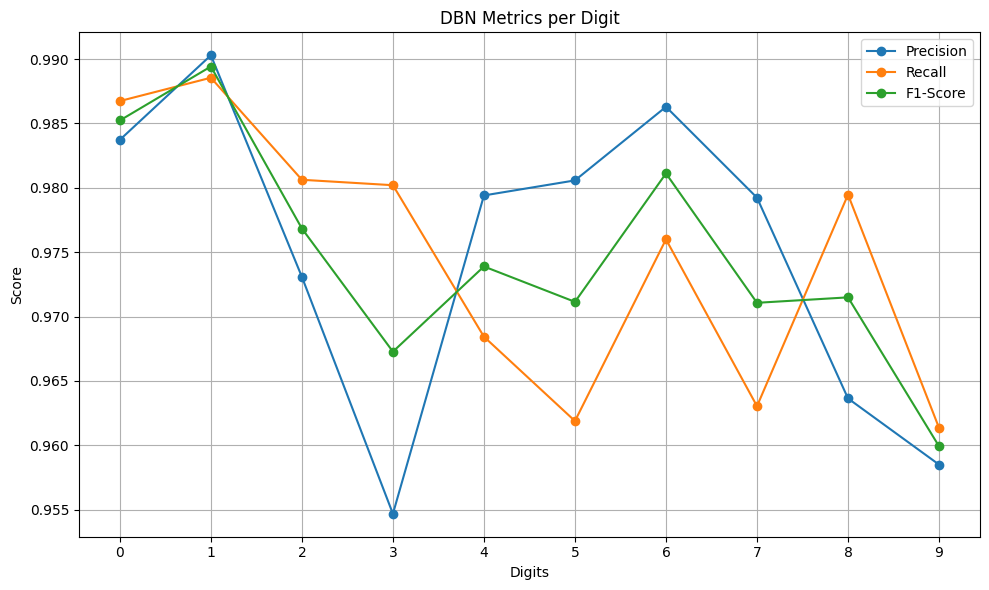

In [ ]:
# DBN metrics for each digit
digits = np.arange(10)
precision = [0.983723, 0.990291, 0.973077, 0.954677, 0.979403, 0.980571, 0.986287, 0.979228, 0.963636, 0.958498]
recall = [0.986735, 0.988546, 0.980620, 0.980198, 0.968432, 0.961883, 0.975992, 0.963035, 0.979466, 0.961348]
f1_score = [0.985227, 0.989418, 0.976834, 0.967269, 0.973886, 0.971138, 0.981112, 0.971064, 0.971487, 0.959921]

# Plotting the line graph
plt.figure(figsize=(10, 6))

plt.plot(digits, precision, label="Precision", marker='o')
plt.plot(digits, recall, label="Recall", marker='o')
plt.plot(digits, f1_score, label="F1-Score", marker='o')

plt.xlabel("Digits")
plt.ylabel("Score")
plt.title("DBN Metrics per Digit")
plt.xticks(digits)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


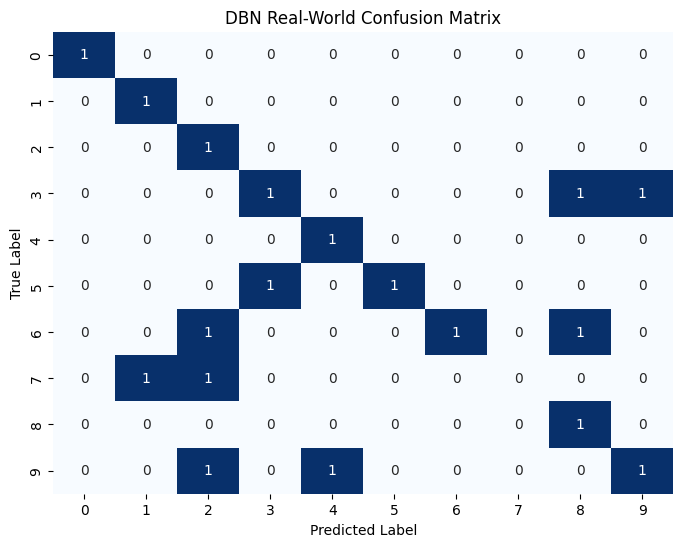

In [ ]:
# Confusion matrix for DBN (real-world metrics)
dbn_confusion_matrix = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Digit 0
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # Digit 1
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Digit 2
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1],  # Digit 3 misclassified as 8 or 9
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # Digit 4
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],  # Digit 5 misclassified as 3
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],  # Digit 6 misclassified as 2 or 8
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],  # Digit 7 misclassified as 1 or 2
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # Digit 8
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 1]   # Digit 9 misclassified as 2, 4, or 9
])

# Plotting the confusion matrix heatmap for DBN
plt.figure(figsize=(8, 6))
sns.heatmap(dbn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('DBN Real-World Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
